In [41]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

def plot_img(img, f_size=(10,10)):
    plt.figure(figsize=f_size)
    plt.imshow(img)

### PatchMatch

0
1
2
3
4
419.3150153160095


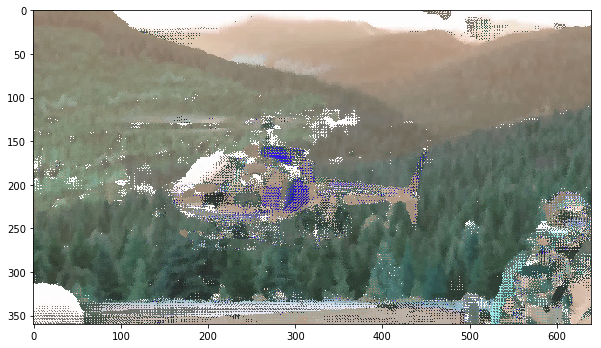

In [51]:

def patch_match(a, b, n_iter = 5):
    
    np.random.seed(1000)
    
    box_size=7
    
    half_box_size = box_size // 2
    
    a_w, a_h = a.shape[0], a.shape[1]
    b_w, b_h = b.shape[0], b.shape[1]
    
    def distance(pa, pb):
        
        x_s = y_s = half_box_size
        x_e = y_e = half_box_size + 1
        x_s = min(pa[0], pb[0], x_s)
        x_e = min(a_w - pa[0], b_w-pb[0], x_e)
        y_s = min(pa[1], pb[1], y_s)
        y_e = min(a_h - pa[1], b_h-pb[1], y_e)
        
        return np.sum(
            (a[pa[0]-x_s:pa[0]+x_e, pa[1]-y_s:pa[1]+y_e] - b[pb[0]-x_s:pb[0]+x_e, pb[1]-y_s:pb[1]+y_e])**2
        ) / ((x_s + x_e) * (y_s + y_e))
    
    
    def random_init():        
        values = np.zeros((2, a_w, a_h)).astype(np.int)
        distances = np.zeros((a_w, a_h))

        values[0] = np.random.randint(b_w, size=(a_w, a_h))
        values[1] = np.random.randint(b_h, size=(a_w, a_h))

        values = values.transpose((1, 2 ,0))
        
        for i in range(a_w):
            for j in range(a_h):
                p = values[i,j]
                distances[i,j] = distance( (i, j), (p[0], p[1]) )

        return values, distances
    
    def iterate(n_iter = 5):
        
        offset = half_box_size
        
        neighd = [
            [0, -offset],
            [offset, -offset],
            [offset, 0],
            [offset, offset],
            [0, offset],
            [-offset, offset],
            [-offset, 0],
            [-offset, -offset]
        ]
        
        for iteration in range(n_iter):
            print(iteration)
            for i in range(a_w):                
                for j in range(a_h):
                    
                    p = values[i,j]
                    x, y = p[0], p[1]
                    optimal_x, optimal_y, min_dist = x, y, distances[i,j]
                    
                    for ng in neighd:
                        if (
                            i + ng[0] >= 0 and
                            i + ng[0] < a_w and
                            j + ng[1] >= 0 and
                            j + ng[1] < a_h
                        ):
                            cx, cy = values[i + ng[0], j + ng[1]]
                            if (
                                cx >= 0 and
                                cx < b_w and
                                cy >= 0 and
                                cy < b_h
                            ):
                                dist = distance( (i, j), (cx, cy))
                                if dist < min_dist:
                                    optimal_x, optimal_y, min_dist = cx, cy, dist
                                    
                                    
                    rand_d = min(b_w//2, b_h//2)
                    while rand_d > 0:
                        try:
                            xmin = max(optimal_x - rand_d, 0)
                            xmax = min(optimal_x + rand_d, b_w)
                            ymin = max(optimal_y - rand_d, 0)
                            ymax = min(optimal_y + rand_d, b_h)

                            cx = np.random.randint(xmin, xmax)
                            cy = np.random.randint(ymin, ymax)
                            dist = distance((i, j), (cx, cy))
                            if dist < min_dist:
                                optimal_x, optimal_y, min_dist = cx, cy, dist
                        except:
                            pass
                        rand_d = rand_d // 2

                    values[i, j] = [optimal_x, optimal_y]
                    distances[i, j] = min_dist
            
    def reconstr():
        result = np.zeros_like(a)
        for i in range(a_w):
            for j in range(a_h):
                p = values[i,j]
                result[i,j] = b[p[0], p[1]]
        return result
    

    values, distances = random_init()
    iterate(n_iter = n_iter)
    
    return reconstr()
    
    


a = cv2.imread('./images/task_6/v001.jpg')
b = cv2.imread('./images/task_6/v010.jpg')

a = cv2.resize(a, (0,0), fx=0.5, fy=0.5)
b = cv2.resize(b, (0,0), fx=0.5, fy=0.5)

start = time.time()

result = patch_match(a, b, n_iter = 5)

print(time.time() - start)

# reconstructed image
plot_img(result)

### Image A and B

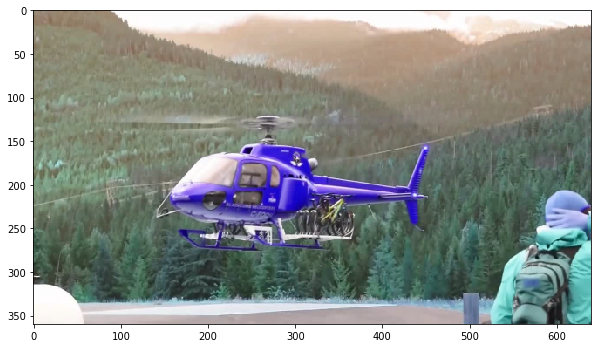

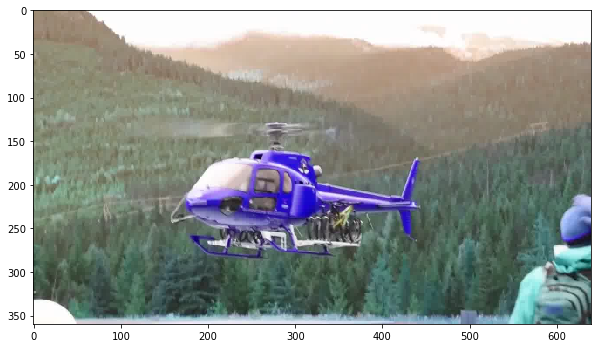

In [52]:
plot_img(a)
plot_img(b)